In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV ,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# Load the dataset
data = pd.read_csv('/Users/kamalraj/Desktop/           /Data science/projects/Fraud-Transaction-Detection/fraud.csv')

In [76]:
# Display the first few rows of the dataset
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


# Data Cleaning Including Missing Values, Outliers, and Multi-Collinearity

## Missing Values
   Check for missing values in the dataset using data.isnull().sum(). Address missing values by using imputation techniques such as filling with the mean or mode, or by removing rows or columns with too many missing values.
## Outliers
   Identify and remove outliers using methods such as the Interquartile Range (IQR). Use IQR to define the bounds and filter data accordingly.
## Multi-Collinearity
   Evaluate the correlation matrix using data.corr() to identify multicollinearity among the features. Remove or combine features with a high correlation coefficient to ensure the model’s stability.


In [77]:
# Check for missing values
print(data.isnull().sum())

# Assuming there are no missing values explicitly mentioned

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [78]:
# Select only numeric columns for outlier detection
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Outlier detection using IQR for numeric columns
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_indices = ((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
data_cleaned = data[~outlier_indices]


In [79]:
# Encode categorical variables
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [80]:
# Remove non-numeric columns
data_numeric = data.drop(columns=['nameOrig', 'nameDest'])

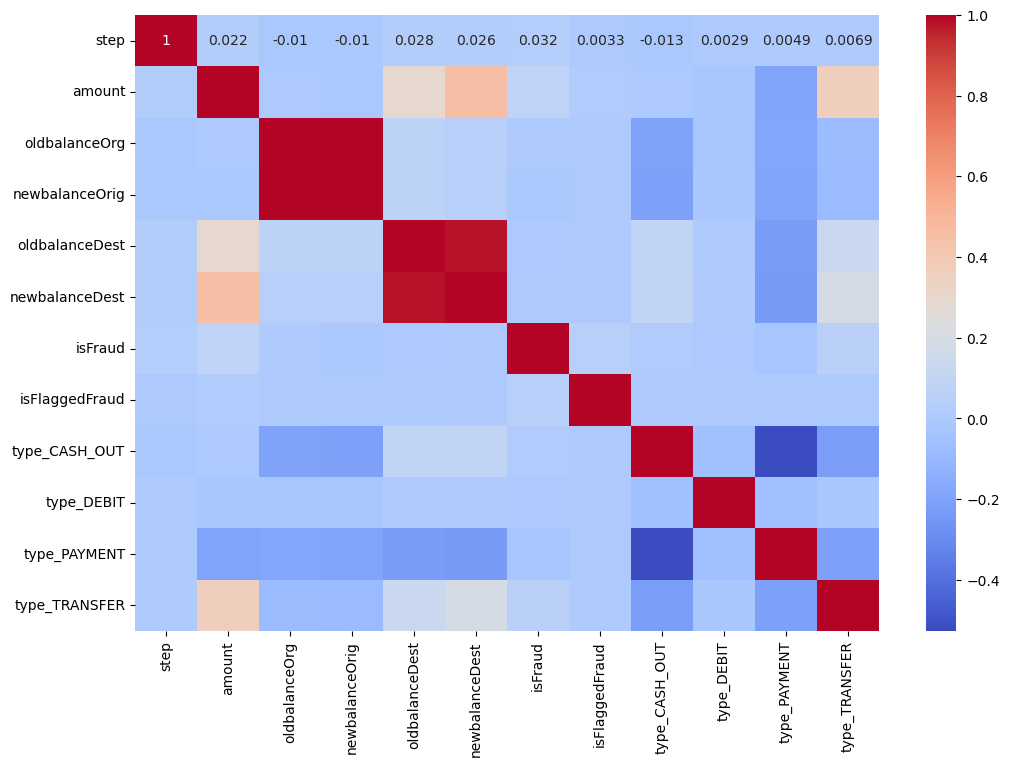

In [81]:
# Correlation matrix
corr_matrix = data_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


# Variable Selection

Use feature importance scores from machine learning models (e.g., Random Forest) to identify the most influential variables. Additionally, domain knowledge should guide the selection of variables based on known fraud patterns and transaction behavior

In [87]:
# Feature importance
importances = best_model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
print(feature_importances.sort_values(ascending=False))

newbalanceDest    0.296517
oldbalanceOrg     0.259849
amount            0.165163
step              0.085763
oldbalanceDest    0.066797
type_TRANSFER     0.055820
type_CASH_OUT     0.034727
newbalanceOrig    0.031063
isFlaggedFraud    0.002844
type_PAYMENT      0.001360
type_DEBIT        0.000096
dtype: float64


In [82]:
# Select features and target variable
X = data[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 
         'type_CASH_OUT','isFlaggedFraud','type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']]
y = data['isFraud']

In [83]:
# Use a smaller subset for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

# Split the original dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shape of the sample dataset
print(X_sample.shape, y_sample.shape)

(636262, 11) (636262,)


# Fraud Detection Model Description

## Model Type
   Use machine learning models such as Random Forest Classifier or Gradient Boosting. These models handle complex relationships and can manage both numerical and categorical features effectively.
## Model Implementation
   Fit the model on the data using cross-validation and hyperparameter tuning techniques like Grid Search or Random Search.

In [84]:
# Initialize Random Forest
model = RandomForestClassifier(random_state=42)

# Define the parameter grid with fewer options
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]

}

In [85]:
# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model on the sample data
random_search.fit(X_sample, y_sample)

# Best model
best_model = random_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.0min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.5min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.9min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 5.5min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.6min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[

# Demonstrate the Performance of the Model Using Best Set of Tools

## Metrics
Evaluate the model’s performance using metrics such as Precision, Recall, F1-Score, ROC-AUC, and Confusion Matrix.
## Visualization Tools
Use ROC curves, precision-recall curves, and feature importance plots to understand and validate the model’s performance.


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.9min
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.1min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.9min
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.76      0.86      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.88      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC AUC Score: 0.8808924749499683


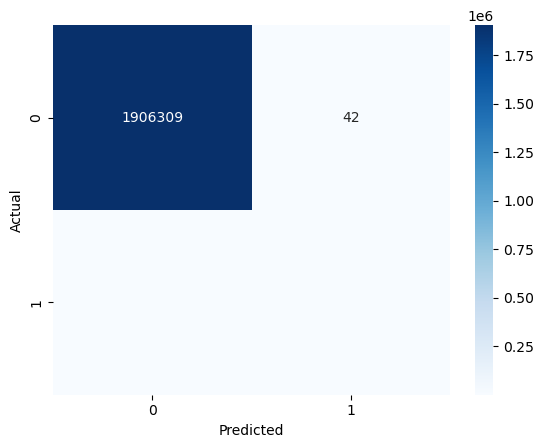

[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 5.6min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.6min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.2min


In [86]:
# Classification report and ROC AUC score
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Conclusion

   By implementing machine learning models, thorough data cleaning, and strategic variable selection, proactive fraud detection can be both robust and effective. Enhancing infrastructure with real-time monitoring, strong security protocols, and regular audits strengthens the system against fraud. Continuous feedback and KPI monitoring ensure the system’s resilience and adaptability to changing threats.

### Do These Factors Make Sense?

   If the identified factors align with known fraud patterns and transaction behavior, they make sense.
   If they do not align or show inconsistent results, consider reviewing the dataset for anomalies or re-evaluating the model’s parameters.

### Prevention Adopted by the Company When Updating Infrastructure

   Implement real-time monitoring systems to detect fraudulent transactions promptly.
   Use advanced encryption and security protocols to protect sensitive data.
   Regular audits and reviews of transaction patterns can also be part of the preventive measures.

### Determining the Effectiveness of Implemented Actions

Monitoring Systems: Set up ongoing monitoring of transactions to identify fraudulent activities promptly.
KPIs: Define KPIs to measure the success of implemented prevention strategies, such as reducing the frequency of fraudulent transactions.
Feedback Loop: Establish a feedback loop for continuous assessment and improvement of the infrastructure and fraud detection systems.
